### Huge demand and potential for online ecommerce. Companies have been leveraging data analysis to understand customer behavior, market trends, and machine learning for product recommendations. 

### In this project, I analyzed online grocery shopping data to gain insights about customer purchase and market trends. 

### Further I built a product recommender system that recommends products for a given user based on the available order history and similar user ratings. 

In [95]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://assets.skyfilabs.com/images/blog/online-grocery-recommendation-using-machine-learning.webp")

In [1]:
# Importing the necessary libraries, starting from EDA to ML used later on
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkConf
from pyspark.sql import functions
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import warnings
from pymongo import MongoClient
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

## Importing data into MongoDB

The CSV files are read using the pandas library. These pandas dataframes are converted to dictionaries and imported to 5 different collections of a MongoDB database.

In [3]:
# Using the Pandas library to read the CSV files 
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
order_products = pd.read_csv('order_products__prior.csv')

In [4]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [5]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [8]:
order_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [9]:
# Connecting to MongoDB server, and creating a new database named DATA603 and 5 collections within the database
client = MongoClient('mongodb://localhost:27017/')
db = client['DATA603']
collection_products = db['products']
collection_aisles = db['aisles']
collection_departments = db['departments']
collection_order_products = db['order_products']
collection_orders = db['orders']

In [11]:
# inserting products data into the collection products
products.reset_index(inplace=True)
data_dict_products = products.to_dict("records")
collection_products.insert_many(data_dict_products)

In [12]:
# inserting aisles data into the collection aisles
aisles.reset_index(inplace=True)
data_dict_aisles = aisles.to_dict("records")
collection_aisles.insert_many(data_dict_aisles)

In [13]:
# inserting departments data into the collection departments
departments.reset_index(inplace=True)
data_dict_departments = departments.to_dict("records")
collection_departments.insert_many(data_dict_departments)

In [14]:
# inserting order_products data into the collection order_products
order_products.reset_index(inplace=True)
data_dict_order_products = order_products.to_dict("records")
collection_order_products.insert_many(data_dict_order_products)

In [17]:
# inserting orders data into the collection orders
orders.reset_index(inplace=True)
data_dict_orders = orders.to_dict("records")
collection_orders.insert_many(data_dict_orders)

## Importing data from MongoDB to Spark

Now we start a Spark session and import the 5 collections into 5 different Spark dataframes. Then these spark dataframes will be merged to form a single spark dataframe that will be used for further analysis. 

In [10]:
# Setting up the PySpark configuration to be used with Python

conf = pyspark.SparkConf().set("spark.jars.packages",
                              "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1").setMaster("local").setAppName("My App").setAll([("spark.driver.memory","20g"),("spark.executor.memory","20g"), ("spark.driver.maxResultSize", "10g")])

sc = SparkContext(conf=conf)
spark = SparkSession(sc)

c:\users\suhet\appdata\local\programs\python\python36\lib\site-packages\pyspark\context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


Data is stored in the 'DATA603' Database. 

In [11]:
# specifying the MongoDB database path
mongo_ip = "mongodb://localhost:27017/DATA603."

In [12]:
sqlC = SQLContext(sc)

In [13]:
# Reading data from MongoDB collections into Spark dataframes

spk_products = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",mongo_ip+"products").load()
spk_aisles = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",mongo_ip+"aisles").load()
spk_departments = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",mongo_ip+"departments").load()
spk_order_products = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",mongo_ip+"order_products").load()
spk_orders = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",mongo_ip+"orders").load()

In [14]:
# Creating a view for each of the spark dataframes
spk_products.createOrReplaceTempView("products")
products = sqlC.sql("SELECT * FROM products")
products = products.drop("_id")
products.show(5)

+--------+-------------+-----+----------+--------------------+
|aisle_id|department_id|index|product_id|        product_name|
+--------+-------------+-----+----------+--------------------+
|      61|           19|    0|         1|Chocolate Sandwic...|
|     104|           13|    1|         2|    All-Seasons Salt|
|      94|            7|    2|         3|Robust Golden Uns...|
|      38|            1|    3|         4|Smart Ones Classi...|
|       5|           13|    4|         5|Green Chile Anyti...|
+--------+-------------+-----+----------+--------------------+
only showing top 5 rows



In [15]:
products.printSchema()

root
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)



In [16]:
spk_aisles.createOrReplaceTempView("aisles")
aisles = sqlC.sql("SELECT * FROM aisles")
aisles = aisles.drop("_id")
aisles.show(5)

+--------------------+--------+-----+
|               aisle|aisle_id|index|
+--------------------+--------+-----+
|prepared soups sa...|       1|    0|
|   specialty cheeses|       2|    1|
| energy granola bars|       3|    2|
|       instant foods|       4|    3|
|marinades meat pr...|       5|    4|
+--------------------+--------+-----+
only showing top 5 rows



In [17]:
aisles.printSchema()

root
 |-- aisle: string (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- index: integer (nullable = true)



In [18]:
spk_departments.createOrReplaceTempView("departments")
departments = sqlC.sql("SELECT * FROM departments")
departments = departments.drop("_id")
departments.show(5)

+----------+-------------+-----+
|department|department_id|index|
+----------+-------------+-----+
|    frozen|            1|    0|
|     other|            2|    1|
|    bakery|            3|    2|
|   produce|            4|    3|
|   alcohol|            5|    4|
+----------+-------------+-----+
only showing top 5 rows



In [19]:
departments.printSchema()

root
 |-- department: string (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- index: integer (nullable = true)



In [20]:
spk_order_products.createOrReplaceTempView("order_products")
order_products = sqlC.sql("SELECT * FROM order_products")
order_products = order_products.drop("_id")
order_products.show(5)

+-----------------+-----+--------+----------+---------+
|add_to_cart_order|index|order_id|product_id|reordered|
+-----------------+-----+--------+----------+---------+
|                1|    0|       2|     33120|        1|
|                2|    1|       2|     28985|        1|
|                3|    2|       2|      9327|        0|
|                4|    3|       2|     45918|        1|
|                5|    4|       2|     30035|        0|
+-----------------+-----+--------+----------+---------+
only showing top 5 rows



In [21]:
order_products.printSchema()

root
 |-- add_to_cart_order: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- reordered: integer (nullable = true)



In [22]:
spk_orders.createOrReplaceTempView("orders")
orders = sqlC.sql("SELECT * FROM orders")
orders = orders.drop("_id")
orders.show(5)

+----------------------+--------+-----+---------+-----------------+--------+------------+-------+
|days_since_prior_order|eval_set|index|order_dow|order_hour_of_day|order_id|order_number|user_id|
+----------------------+--------+-----+---------+-----------------+--------+------------+-------+
|                   NaN|   prior|    0|        2|                8| 2539329|           1|      1|
|                  15.0|   prior|    1|        3|                7| 2398795|           2|      1|
|                  21.0|   prior|    2|        3|               12|  473747|           3|      1|
|                  29.0|   prior|    3|        4|                7| 2254736|           4|      1|
|                  28.0|   prior|    4|        4|               15|  431534|           5|      1|
+----------------------+--------+-----+---------+-----------------+--------+------------+-------+
only showing top 5 rows



In [23]:
orders.printSchema()

root
 |-- days_since_prior_order: double (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- index: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- user_id: integer (nullable = true)



## Merging the Spark Dataframes to get a single Dataframe

In [84]:
# The different Spark dataframes are used to merged using inner joins

df = products.join(aisles,products.aisle_id ==  aisles.aisle_id,"inner")
df = df.join(departments, df.department_id == departments.department_id, "inner")
df = df.join(order_products, df.product_id == order_products.product_id, "inner")
groceries = df.join(orders, df.order_id == orders.order_id, "inner")

## Preliminary Exploratory Data Analysis

Lets look at some of the statistics of some of the columns in the merged dataframe named 'groceries'.

In [25]:
groceries.describe(['add_to_cart_order', 'order_dow', 'order_hour_of_day']).show()

+-------+-----------------+------------------+------------------+
|summary|add_to_cart_order|         order_dow| order_hour_of_day|
+-------+-----------------+------------------+------------------+
|  count|         32434489|          32434489|          32434489|
|   mean|8.351075517175559|2.7388176826217303|13.424977405995204|
| stddev|7.126671161204414| 2.090049080945604| 4.246364995781053|
|    min|                1|                 0|                 0|
|    max|              145|                 6|                23|
+-------+-----------------+------------------+------------------+



### **Which day of the week most orders are placed?**

Based on the below graph, Sunday seems to be the day most orders are placed. This is expected as people stock up for the week. Monday is the next day with most orders. 

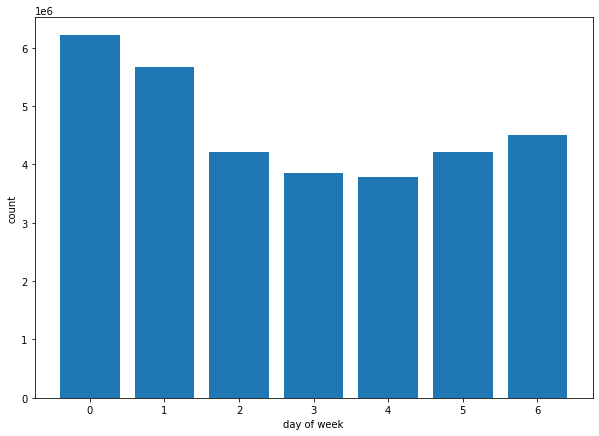

In [26]:
# Using groupBy to group the rows based on order_dow
df0 = groceries.groupBy("order_dow").count().sort(functions.desc('count'))
pdf0 = df0.toPandas()

# Figure Size
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
plt.bar(pdf0['order_dow'], pdf0['count'])
plt.xlabel('day of week')
plt.ylabel('count')

# Show Plot
plt.show()

### **Which hour of the day most orders are placed?**

As shown below, most of the orders are placed in the hours from 10 am - 4 pm. It is expected that more orders are placed during the day.

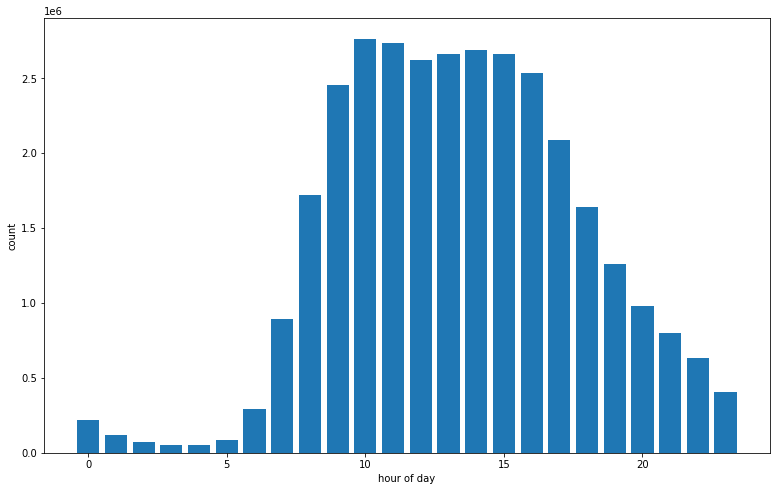

In [27]:
# Using groupBy to group the rows based on order_hour_of_day
df1 = groceries.groupBy("order_hour_of_day").count().sort(functions.desc('count'))
pdf1 = df1.toPandas()

pdf1 = pdf1.astype({"order_hour_of_day": int}, errors='raise') 
pdf1.sort_values(by='order_hour_of_day', ascending=False)

# Figure Size
fig = plt.figure(figsize =(13, 8))
 
# Horizontal Bar Plot
plt.bar(pdf1['order_hour_of_day'], pdf1['count'])
plt.xlabel('hour of day')
plt.ylabel('count')
 
# Show Plot
plt.show()

### **Which aisles are most busy?**

In [28]:
# Using groupBy to group the rows based on aisle
groceries.groupBy("aisle").count().sort(functions.desc('count')).show()

+--------------------+-------+
|               aisle|  count|
+--------------------+-------+
|        fresh fruits|3642188|
|    fresh vegetables|3418021|
|packaged vegetabl...|1765313|
|              yogurt|1452343|
|     packaged cheese| 979763|
|                milk| 891015|
|water seltzer spa...| 841533|
|      chips pretzels| 722470|
|     soy lactosefree| 638253|
|               bread| 584834|
|        refrigerated| 575881|
|      frozen produce| 522654|
|       ice cream ice| 498425|
|            crackers| 458838|
| energy granola bars| 456386|
|                eggs| 452134|
|          lunch meat| 395130|
|        frozen meals| 390299|
|   baby food formula| 382456|
|         fresh herbs| 377741|
+--------------------+-------+
only showing top 20 rows



### **Which aisles are most busy in a given hour of the day?**


Understanding which aisle is most busy in the different hours of the day can help the company stock up and place more staff at the warehouses and for delivery. It is seen that 'fresh fruits and veggies' are the ordered throughout the day and they need to be stocked up regularly. 

In [29]:
# groupBy both aisle and order_hour_of_day to get a count of unique combinations of these two

groceries.groupBy(["aisle", "order_hour_of_day"]).count().sort(functions.desc('count')).show(50)

+--------------------+-----------------+------+
|               aisle|order_hour_of_day| count|
+--------------------+-----------------+------+
|        fresh fruits|               10|312136|
|        fresh fruits|               11|300546|
|        fresh fruits|               14|296705|
|        fresh fruits|               15|294719|
|        fresh fruits|               13|291146|
|    fresh vegetables|               11|290162|
|        fresh fruits|                9|289416|
|    fresh vegetables|               14|289391|
|    fresh vegetables|               13|288620|
|    fresh vegetables|               12|285877|
|    fresh vegetables|               15|285143|
|        fresh fruits|               12|284278|
|    fresh vegetables|               10|282583|
|        fresh fruits|               16|280764|
|    fresh vegetables|               16|268682|
|    fresh vegetables|                9|242885|
|        fresh fruits|               17|227493|
|    fresh vegetables|               17|

### **How often do people place grocery orders?**

This can be inferred from the days since prior order information. It is seen that moslty people have ordered prior to 7 days and 30 days. This is also expected as people generally stock up weekly or monthly.  

In [30]:
pdf2 = groceries.select('days_since_prior_order').toPandas().value_counts()

In [31]:
x = []
for i in pdf2.index:
    x.append(i[0])

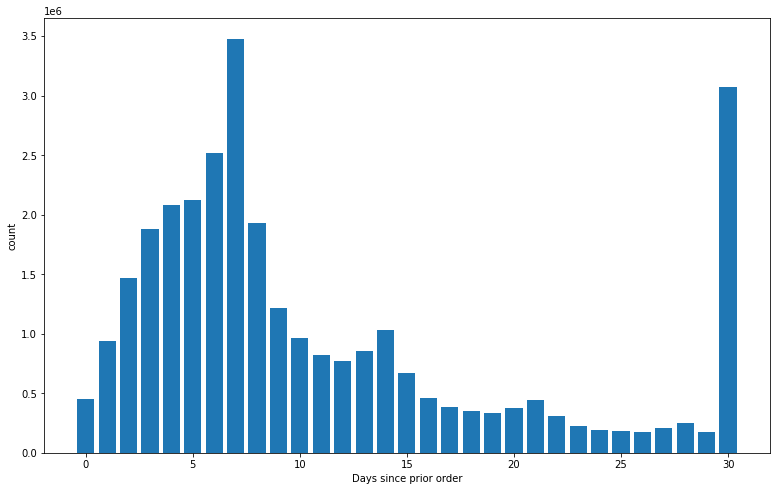

In [32]:
# Figure Size
fig = plt.figure(figsize =(13, 8))
 
# Horizontal Bar Plot
plt.bar(x, pdf2)
plt.xlabel('Days since prior order')
plt.ylabel('count')
 
# Show Plot
plt.show()

### **Which department is most busy?**

From the below graph, we can infer that the produce department is most busy. This is also expected as the produce products need to be used up quickly and therefore are ordered more frequently. 

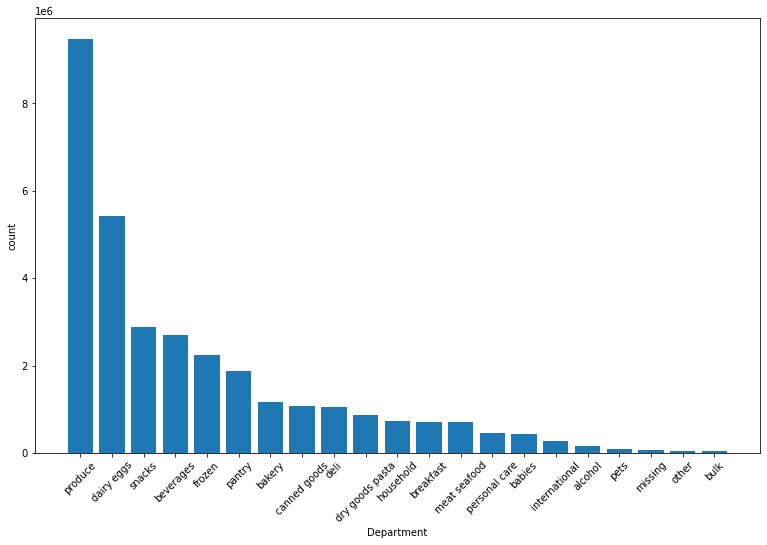

In [33]:
# Using groupBy to group the rows based on department
dept = groceries.groupBy(["department"]).count().sort(functions.desc('count'))
dept_df = dept.toPandas()

# Figure Size
fig = plt.figure(figsize =(13, 8))
 
# Horizontal Bar Plot
plt.bar(dept_df['department'], dept_df['count'])
plt.xlabel('Department')
plt.ylabel('count')

plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees

# Show Plot
plt.show()

### **Which departments are most busy in a given hour of the day?**

In [37]:
# Using groupBy for both department and order_hour_of_day 
groceries.groupBy(["department", "order_hour_of_day"]).count().sort(functions.desc('count')).show(50)

+----------+-----------------+------+
|department|order_hour_of_day| count|
+----------+-----------------+------+
|   produce|               10|800246|
|   produce|               11|796168|
|   produce|               14|786408|
|   produce|               13|778947|
|   produce|               15|776735|
|   produce|               12|768606|
|   produce|               16|735083|
|   produce|                9|714001|
|   produce|               17|594432|
|   produce|                8|510782|
|dairy eggs|               10|470549|
|   produce|               18|462060|
|dairy eggs|               11|453142|
|dairy eggs|               14|442690|
|dairy eggs|               15|437459|
|dairy eggs|               13|434851|
|dairy eggs|                9|430038|
|dairy eggs|               12|426895|
|dairy eggs|               16|417760|
|   produce|               19|355431|
|dairy eggs|               17|340709|
|dairy eggs|                8|307420|
|   produce|               20|287986|
|dairy eggs|

### **Which products have most demand?**

Based on this, we can understand the consumption trends and stock up products accordingly to keep the business running efficiently. Products from the produce department are the most consumed. Within the produce department, bananas, spinach and avacados are among the top products that are consumed. 

In [38]:
groceries.groupBy(["product_name"]).count().sort(functions.desc('count')).show(50)

+--------------------+------+
|        product_name| count|
+--------------------+------+
|              Banana|472565|
|Bag of Organic Ba...|379450|
|Organic Strawberries|264683|
|Organic Baby Spinach|241921|
|Organic Hass Avocado|213584|
|     Organic Avocado|176815|
|         Large Lemon|152657|
|        Strawberries|142951|
|               Limes|140627|
|  Organic Whole Milk|137905|
| Organic Raspberries|137057|
|Organic Yellow Onion|113426|
|      Organic Garlic|109778|
|    Organic Zucchini|104823|
| Organic Blueberries|100060|
|      Cucumber Kirby| 97315|
|  Organic Fuji Apple| 89632|
|       Organic Lemon| 87746|
|Apple Honeycrisp ...| 85020|
|Organic Grape Tom...| 84255|
| Seedless Red Grapes| 82689|
|    Organic Cucumber| 80392|
|    Honeycrisp Apple| 79769|
|Organic Baby Carrots| 76896|
| Organic Half & Half| 76360|
|Sparkling Water G...| 75886|
|Organic Large Ext...| 75165|
|       Yellow Onions| 73167|
| Organic Gala Apples| 72846|
|Organic Baby Arugula| 72829|
|         

### **Which products were added first to the cart majority times?**
The products from the fresh produce department are most ordered and also are the ones that are added to the cart initially.

In [41]:
groceries.printSchema()

root
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle: string (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- index: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- user_id: int

In [43]:
groceries.createOrReplaceTempView("groceries")
groceries = sqlC.sql("SELECT * FROM groceries")

In [44]:
# Using Spark SQL querying to find products that were added first to the cart majority of times
add2cart_1 = sqlC.sql("SELECT * FROM groceries WHERE add_to_cart_order == 1")
add2cart_1.groupBy(["product_name"]).count().sort(functions.desc('count')).show(10)

+--------------------+------+
|        product_name| count|
+--------------------+------+
|              Banana|110916|
|Bag of Organic Ba...| 78988|
|  Organic Whole Milk| 30927|
|Organic Strawberries| 27975|
|Organic Hass Avocado| 24116|
|Organic Baby Spinach| 23543|
|     Organic Avocado| 22398|
|        Spring Water| 16822|
|        Strawberries| 16366|
| Organic Raspberries| 14393|
+--------------------+------+
only showing top 10 rows



In [45]:
# Using Spark SQL querying to find products that were added second to the cart majority of times
add2cart_2 = sqlC.sql("SELECT * FROM groceries WHERE add_to_cart_order == 2")
add2cart_2.groupBy(["product_name"]).count().sort(functions.desc('count')).show(10)

+--------------------+-----+
|        product_name|count|
+--------------------+-----+
|              Banana|80432|
|Bag of Organic Ba...|64337|
|Organic Strawberries|29754|
|Organic Hass Avocado|26517|
|Organic Baby Spinach|25025|
|     Organic Avocado|23456|
|  Organic Whole Milk|20888|
|        Strawberries|16969|
| Organic Raspberries|16236|
|         Large Lemon|14233|
+--------------------+-----+
only showing top 10 rows



In [46]:
# Using Spark SQL querying to find products that were added third to the cart majority of times
add2cart_3 = sqlC.sql("SELECT * FROM groceries WHERE add_to_cart_order == 3")
add2cart_3.groupBy(["product_name"]).count().sort(functions.desc('count')).show(10)

+--------------------+-----+
|        product_name|count|
+--------------------+-----+
|              Banana|58577|
|Bag of Organic Ba...|48972|
|Organic Strawberries|27809|
|Organic Baby Spinach|24297|
|Organic Hass Avocado|24212|
|     Organic Avocado|20258|
|        Strawberries|15659|
|  Organic Whole Milk|15617|
| Organic Raspberries|14969|
|         Large Lemon|14243|
+--------------------+-----+
only showing top 10 rows



### **Which hour of the day are each of the departments most busy?**

From the below analysis, we can see that baby products are most ordered in the first busy hour of the day (9am). Breakfast and bakery products are ordered the most at 10 am as expected. Alcohol is most ordered before the evening at around 2 pm.

In [47]:
pdf3 = groceries.select('department', 'order_hour_of_day').toPandas().groupby(['department', 'order_hour_of_day']).size().unstack(fill_value=0)

In [48]:
pdf3

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
department,,,,,,,,,,,,,,,,,,,,,
alcohol,501,318,255,193,198,268,695,2119,5269,10371,...,15093,15140,14286,12098,8816,5846,3358,1984,1407,899
babies,2400,1113,630,465,567,1106,4903,16807,28763,34456,...,34317,32892,30083,23252,18617,16072,16016,14858,10558,5428
bakery,7326,3754,2405,1831,1920,3102,10807,34157,63970,89319,...,98147,98313,94036,77377,59747,45191,34143,27219,21217,13452
beverages,17575,10031,6201,4707,4795,7453,22998,68875,140271,219108,...,221766,219027,209872,174856,138296,105707,75802,55868,43422,29924
breakfast,4368,2379,1412,1072,1112,1893,6830,21811,41342,58915,...,56758,56017,54223,44330,35339,27941,21739,17632,13565,8714
bulk,238,117,66,49,47,78,326,908,1820,2746,...,2767,2861,2567,2127,1640,1323,1155,959,734,503
canned goods,7183,3919,2417,1714,1830,2860,8948,26852,53004,75711,...,91458,89733,83931,67841,51461,39686,31072,26613,21599,13258
dairy eggs,34775,17786,10702,8079,8181,14399,51579,159849,307420,430038,...,442690,437459,417760,340709,268711,207466,163960,134689,105997,66330
deli,6920,3671,2257,1617,1665,2790,8986,27251,52979,76651,...,87574,87705,85267,71185,55301,41302,30597,24509,19900,12904


In [49]:
dep_wise_max_hour = pdf3.idxmax(axis = 1)

In [50]:
# Viewing which hour of the day each of the departments are most busy
dep_wise_max_hour

department
alcohol            15
babies              9
bakery             10
beverages          10
breakfast          10
bulk               10
canned goods       11
dairy eggs         10
deli               11
dry goods pasta    14
frozen             15
household          10
international      15
meat seafood       15
missing            10
other              14
pantry             11
personal care      10
pets               16
produce            10
snacks             10
dtype: int64

## ML Part Start:

## Calculating User Ratings For Products Bought 



In [51]:
groceries.printSchema()

root
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle: string (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- index: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- user_id: int

In [86]:
# Picking only the user_id, product_id and reordered columns to generate user ratings for products
spk_df = groceries.select("user_id","products.product_id","reordered")
df = spk_df.toPandas()
df

,user_id,product_id,reordered
0,41523,34197,1
1,41523,35951,1
2,41523,47209,1
3,41523,21614,1
4,41523,21903,1
...,...,...,...
32434484,113114,20995,1
32434485,113114,28465,1
32434486,113114,48634,1
32434487,113114,24615,1


Here the number of times a product was reordered by a particular user is obtained by grouping by user and product IDs and counting the reordered column.

In [87]:
# GroupBy user_id and product_id to get the reordered count of each user for each product
df2 = df[['user_id', 'product_id', 'reordered']].groupby(by=['user_id', 'product_id']).count()

In [88]:
# Using a scaler to scale the range of count values to [0,1]
scaler = MinMaxScaler()

scaled_rating = scaler.fit_transform(df2[['reordered']])

scaled_rating.max()

0.9999999999999999

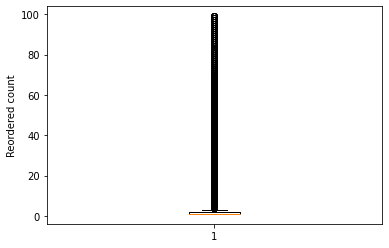

In [89]:
plt.boxplot(df2['reordered'])
plt.ylabel('Reordered count')
plt.show()

In [90]:
# Capping the outliers to 95th quantile from top and 5th quantile from the below end
p_05 = df2['reordered'].quantile(0.05) # 5th quantile
p_95 = df2['reordered'].quantile(0.95) # 95th quantile

df2['reordered'].clip(p_05, p_95, inplace=True)

In [91]:
# Shifting the rating values to the range 0 to 5
scaled_rating = scaler.fit_transform(df2[['reordered']])

df2[['rating']] = scaled_rating*5

In [92]:
df2.drop(['reordered'], axis=1, inplace=True)

In [93]:
df2

rating
user_id product_id          
1       196         5.000000
        10258       5.000000
        10326       0.000000
        12427       5.000000
        13032       1.428571
...                      ...
206209  43961       1.428571
        44325       0.000000
        48370       0.000000
        48697       0.000000
        48742       0.714286

[13307953 rows x 1 columns]

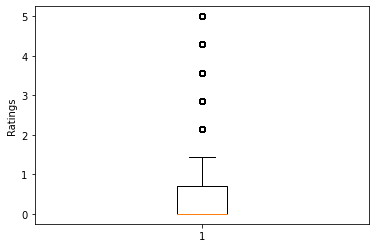

In [94]:
# Boxplot that shows the ratings distribution
plt.boxplot(df2['rating'])
plt.ylabel('Ratings')
plt.show()

This ratings data will be used for Collaborative filtering i.e the recommender system model.

## Storing this dataframe with user ratings for the different products in a MongoDB collection

In [38]:
collection_ratings = db['ratings']
df2.reset_index(inplace=True)
data_dict_ratings = df2.to_dict("records")
collection_ratings.insert_many(data_dict_ratings)

## Collaborative Filtering to build a Recommender System

References:
1. https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#examples
2. https://towardsdatascience.com/building-a-recommendation-system-with-spark-ml-and-elasticsearch-abbd0fb59454
3. https://realpython.com/build-recommendation-engine-collaborative-filtering/

We read the ratings data from MongoDB into a Spark dataframe like before. 

In [53]:
df_ratings = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",mongo_ip+"ratings").load()
df_ratings.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- index: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- user_id: integer (nullable = true)



In [54]:
df_ratings.show()

+--------------------+-----+----------+------------------+-------+
|                 _id|index|product_id|            rating|user_id|
+--------------------+-----+----------+------------------+-------+
|{627f3f3e69932112...|    0|       196|               5.0|      1|
|{627f3f3e69932112...|    1|     10258|               5.0|      1|
|{627f3f3e69932112...|    2|     10326|               0.0|      1|
|{627f3f3e69932112...|    3|     12427|               5.0|      1|
|{627f3f3e69932112...|    4|     13032|1.4285714285714284|      1|
|{627f3f3e69932112...|    5|     13176|0.7142857142857142|      1|
|{627f3f3e69932112...|    6|     14084|               0.0|      1|
|{627f3f3e69932112...|    7|     17122|               0.0|      1|
|{627f3f3e69932112...|    8|     25133|               5.0|      1|
|{627f3f3e69932112...|    9|     26088|0.7142857142857142|      1|
|{627f3f3e69932112...|   10|     26405|0.7142857142857142|      1|
|{627f3f3e69932112...|   11|     30450|               0.0|    

In [55]:
# Drop the index columns that are not useful for modeling
df_ratings = df_ratings.drop("_id")
df_ratings = df_ratings.drop("index")

In [56]:
df_ratings.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- user_id: integer (nullable = true)



Here we will be using the alternating least squares method to get product recommendations. Given a user U, similar users are found based on the given ratings. Using the ratings for an item I by these similar users, rating for the item I that user U might give is predicted. These predicted ratings are used to give recommendations.

In [57]:
%%time

# splitting the data into train and test before training the model
(training, test) = df_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics

als = ALS(maxIter=5, regParam=0.01,implicitPrefs=True,userCol="user_id", itemCol="product_id", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

Wall time: 1min 28s


The metrics used to evaluate recommender systems in general are root mean squared error and mean average error. here we use the root mean squared error to evaluate the model. 

Reference:
https://towardsdatascience.com/evaluating-recommender-systems-root-means-squared-error-or-mean-absolute-error-1744abc2beac#:~:text=Recommender%20System%20accuracy%20is%20popularly,scale%20as%20the%20original%20ratings.

In [58]:
# Evaluate the model by computing the RMSE on the test data

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))


Root-mean-square error = 1.5001006511708599


In [59]:
# Generate top 10 product recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Generate top 10 user recommendations for each product
productRecs = model.recommendForAllItems(10)

In [60]:
# Generate top 10 product recommendations for a specified set of users

users = df_ratings.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 10)

# Generate top 10 user recommendations for a specified set of products

products = df_ratings.select(als.getItemCol()).distinct().limit(3)
productSubSetRecs = model.recommendForItemSubset(products, 10)

We will be using the userRecs dataframe to show top 10 recommendations to a given user. 

In [61]:
userRecs.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    148|[{39275, 0.026372...|
|    463|[{24852, 0.819404...|
|    471|[{16797, 0.133454...|
|    496|[{13176, 0.823444...|
|    833|[{13176, 0.702282...|
|   1088|[{21903, 0.687803...|
|   1238|[{24852, 0.905671...|
|   1342|[{44632, 0.169644...|
|   1580|[{21903, 0.678366...|
|   1591|[{16797, 0.144604...|
|   1645|[{27845, 0.558766...|
|   1829|[{21137, 0.072462...|
|   1959|[{10, 0.0}, {20, ...|
|   2122|[{21137, 0.010012...|
|   2142|[{13176, 1.002904...|
|   2366|[{13176, 0.964151...|
|   2659|[{5077, 0.0730607...|
|   2866|[{44632, 0.859002...|
|   3175|[{21137, 0.087777...|
|   3749|[{47766, 0.731715...|
+-------+--------------------+
only showing top 20 rows



In [62]:
userRecs.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- product_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [63]:
# checking if the recommended products are already bought by the user
#df_ratings[(df_ratings.user_id == 496) & (df_ratings.product_id == 2295)] 

## Making results more interpretable:

Here we will be converting this data into a dictionary with the user ID being the key and the value being a list of recommendations. Using this dictionary, we can access the list of top 10 product recommendations for each user. 

In [64]:
userRecs_pddf = userRecs.toPandas()
userRecs_pddf.set_index('user_id')

,recommendations
user_id,
148,"[(39275, 0.026372693479061127), (7781, 0.02320..."
463,"[(24852, 0.8194042444229126), (13176, 0.779948..."
471,"[(16797, 0.13345454633235931), (27845, 0.10675..."
496,"[(13176, 0.823444664478302), (16797, 0.7448673..."
833,"[(13176, 0.7022829055786133), (21903, 0.607925..."
...,...
204335,"[(24852, 0.8477810621261597), (26209, 0.613738..."
205470,"[(45066, 0.15318265557289124), (4920, 0.130546..."
206049,"[(24852, 0.01949726603925228), (21137, 0.01933..."


We will be extracting the product id's from the list of recommendations.

In [65]:
# Converting the userRecs dataframe into a list
reco = userRecs_pddf.recommendations.tolist()

# b is the list of list of recommendations
b = []
for item in reco:
    lst = item
    # p_lst is the list of product IDs
    p_lst = []
    for p in lst:
        p_lst.append(p[0])
    b.append(p_lst)
    
usr_lst = userRecs_pddf.user_id.tolist()

# using zip()
# to convert lists to dictionary
res = dict(zip(usr_lst, b))

The object 'res' is a dictionary that has user IDs as keys and list of recommended product IDs as the values. 

In [66]:
res

{148: [39275, 7781, 22035, 26604, 22825, 27966, 39928, 37646, 27845, 43961],
 463: [24852, 13176, 47766, 21137, 8277, 30391, 47209, 39275, 40706, 41950],
 471: [16797, 27845, 23909, 28204, 4210, 196, 21137, 9076, 49235, 29487],
 496: [13176, 16797, 27845, 39275, 5077, 4920, 24852, 27966, 26604, 22035],
 833: [13176, 21903, 21137, 47209, 27966, 39275, 42265, 37646, 8277, 35951],
 1088: [21903, 24852, 47626, 49683, 28985, 27845, 45007, 25890, 28204, 4605],
 1238: [24852, 49683, 28204, 29487, 4605, 47626, 28842, 34358, 9076, 26209],
 1342: [44632, 35221, 21709, 30489, 24838, 47766, 27086, 14947, 26620, 20119],
 1580: [21903, 13176, 27845, 21137, 35951, 19660, 27966, 19057, 42265, 22035],
 1591: [16797, 43352, 47766, 39275, 47626, 45066, 26209, 28842, 44142, 21288],
 1645: [27845, 21137, 21903, 27966, 13176, 19057, 19660, 11520, 22935, 3957],
 1829: [21137, 23909, 24852, 4210, 28204, 33198, 29487, 27966, 19057, 26209],
 1959: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 2122: [21137, 33198,

Here we map Product IDs to Product names using the spark dataframe products.

In [71]:
spk_products.createOrReplaceTempView("products")
products = sqlC.sql("SELECT * FROM products")
products = products.drop("_id")

In [72]:
products_df = products.toPandas()
products_df.set_index('product_id', inplace=True)

In [73]:
# b_new is a list of list of product names
b_new = []
for i in b:
    i_new = []
    # i_new is a list of product names
    for j in i:
        i_new.append(products_df["product_name"].loc[j])
    b_new.append(i_new)
    
# using zip()
# to convert lists to dictionary
reco_products = dict(zip(usr_lst, b_new))

The object reco_products is a dictionary with user IDs as keys and recommended product names as the values.

In [74]:
reco_products

{148: ['Organic Blueberries',
  'Organic Sticks Low Moisture Part Skim Mozzarella String Cheese',
  'Organic Whole String Cheese',
  'Organic Blackberries',
  "Organic D'Anjou Pears",
  'Organic Raspberries',
  'Organic Kiwi',
  'Organic Gala Apples',
  'Organic Whole Milk',
  'Organic Peeled Whole Baby Carrots'],
 463: ['Banana',
  'Bag of Organic Bananas',
  'Organic Avocado',
  'Organic Strawberries',
  'Apple Honeycrisp Organic',
  'Organic Cucumber',
  'Organic Hass Avocado',
  'Organic Blueberries',
  'Organic Grape Tomatoes',
  'Organic Tomato Cluster'],
 471: ['Strawberries',
  'Organic Whole Milk',
  '2% Reduced Fat Milk',
  'Organic Fuji Apple',
  'Whole Milk',
  'Soda',
  'Organic Strawberries',
  'Blueberries',
  'Organic Half & Half',
  'Roma Tomato'],
 496: ['Bag of Organic Bananas',
  'Strawberries',
  'Organic Whole Milk',
  'Organic Blueberries',
  '100% Whole Wheat Bread',
  'Seedless Red Grapes',
  'Banana',
  'Organic Raspberries',
  'Organic Blackberries',
  'Organ

## Getting interactive results:

We define a function that returns a list of top 10 product recommendations for a given user.

In [97]:
uid = int(input("Enter the user_id for who you want recommendations: " ))

# Function that returns the top 10 recommendations given the user id
def user_reco(uid):
    return(reco_products[uid])

print('\nThe user may be interested in the following products:')
for item in user_reco(uid):
    print(item)

Enter the user_id for who you want recommendations: 148

The user may be interested in the following products:
Organic Blueberries
Organic Sticks Low Moisture Part Skim Mozzarella String Cheese
Organic Whole String Cheese
Organic Blackberries
Organic D'Anjou Pears
Organic Raspberries
Organic Kiwi
Organic Gala Apples
Organic Whole Milk
Organic Peeled Whole Baby Carrots


### References:
    1. https://medium.com/analytics-vidhya/how-to-upload-a-pandas-dataframe-to-mongodb-ffa18c0953c1
    2. https://www.mongodb.com/docs/spark-connector/master/python/read-from-mongodb/
    3. https://www.mongodb.com/docs/spark-connector/master/scala/datasets-and-sql/
    4. https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#examples
    5. https://towardsdatascience.com/building-a-recommendation-system-with-spark-ml-and-elasticsearch-abbd0fb59454
    6. https://realpython.com/build-recommendation-engine-collaborative-filtering/
    7. https://towardsdatascience.com/evaluating-recommender-systems-root-means-squared-error-or-mean-absolute-error-1744abc2beac#:~:text=Recommender%20System%20accuracy%20is%20popularly,scale%20as%20the%20original%20ratings.